# APS1070, Fall 2024
#### Tutorial 2 - Anomaly Detection Algorithm using Gaussian Mixture Model


In this part of tutorial, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

#make_blobs will generate isotropic Gaussian blobs for clustering.
X, y_true = make_blobs(n_samples=400, centers=1, cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1, cluster_std=5,random_state=0)
#X generated samples, y labels for cluster membership of each sample
print(X.shape, y_true.shape)
print(X_append.shape, y_true_append.shape)

(400, 2) (400,)
(10, 2) (10,)


In [2]:
print(X[0:5], '\n\n',y_true[:5])
print('\n\n',X_append[0:5], '\n\n',y_true_append[:5])

[[ 0.89763767  4.98363526]
 [ 1.07627418  4.68480619]
 [ 1.01618041  4.48527047]
 [ 0.96605783  4.53127837]
 [-0.08485299  4.5170764 ]] 

 [0 0 0 0 0]


 [[  4.7814587    4.91216241]
 [ 10.31406003  -0.58260207]
 [-11.788679     7.5718803 ]
 [  3.19558624   5.97215896]
 [  5.86996     15.50825332]] 

 [0 0 0 0 0]


(410, 2)
(410,)
[[ 4.98363526  0.89763767]
 [ 4.68480619  1.07627418]
 [ 4.48527047  1.01618041]
 [ 4.53127837  0.96605783]
 [ 4.5170764  -0.08485299]]


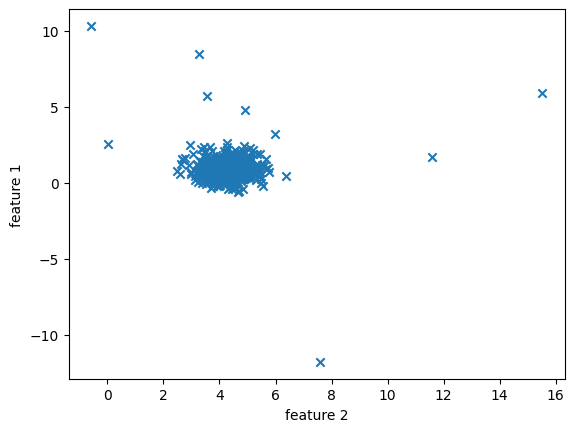

In [3]:
#concatenation along the first axis
X = np.vstack([X,X_append])
print(X.shape)
#concatenation along the second axis
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
print(y_true.shape)
set(y_true)
X = X[:, ::-1] # flip axes for better plotting
print(X[:5])
plt.scatter(X[:,0],X[:,1],marker="x")
plt.xlabel('feature 2')
plt.ylabel('feature 1')
plt.show()

In [4]:
print(X[:5])
X = X[:, ::-1] # flip axes for better plotting
X[:5]

[[ 4.98363526  0.89763767]
 [ 4.68480619  1.07627418]
 [ 4.48527047  1.01618041]
 [ 4.53127837  0.96605783]
 [ 4.5170764  -0.08485299]]


array([[ 0.89763767,  4.98363526],
       [ 1.07627418,  4.68480619],
       [ 1.01618041,  4.48527047],
       [ 0.96605783,  4.53127837],
       [-0.08485299,  4.5170764 ]])

In [5]:
y_true_append

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
[1 for _ in y_true_append]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
make_blobs

<function sklearn.datasets._samples_generator.make_blobs(n_samples=100, n_features=2, *, centers=None, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=None, return_centers=False)>

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers?

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are going to calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulas:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [8]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """

    m = X.shape[0]

    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_

    # compute variance of X
    var = 1/m * np.sum((X - mu)**2,axis=0)

    return mu,var
mu, sigma2 = estimateGaussian(X)

print(mu)
print(sigma2)

[0.9756171  4.30770882]
[1.25990509 0.94147734]


Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [9]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)

    sigma2=np.diag(sigma2)
    X = X - mu.T
    #pinv will calculate Moore-Penrose pseudo-inverse of A
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma2)

In [10]:
sigma2 = np.diag(sigma2)
print('sigma2:\n', sigma2)
print('pseudo-inverse of sigma2:\n', np.linalg.pinv(sigma2))

sigma2:
 [[1.25990509 0.        ]
 [0.         0.94147734]]
pseudo-inverse of sigma2:
 [[0.79371058 0.        ]
 [0.         1.06216046]]


In [11]:
print(p.shape)
print(p[:5])


(410,)
[0.11437256 0.13495896 0.14361205 0.14229909 0.09137122]


Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

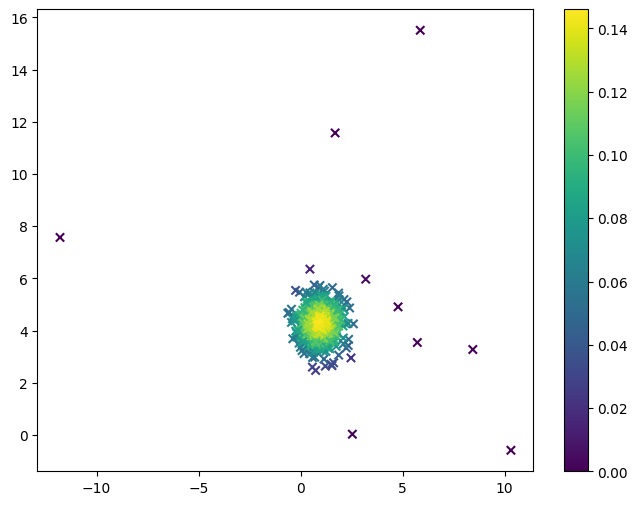

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programmatically  identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [13]:
#Choose a value for Threshold
print (p.min() , p.max())

1.2623338074896085e-34 0.14606732453094934


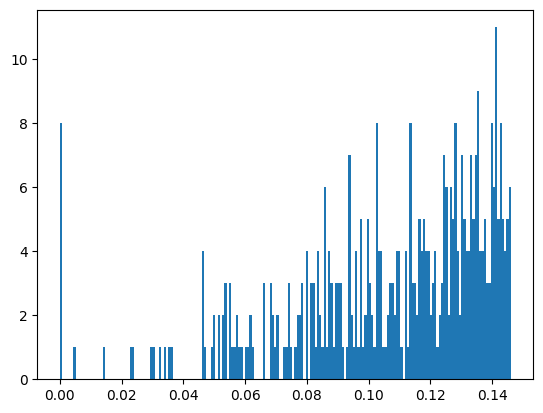

In [14]:
_ = plt.hist (p, bins = 200)

In [15]:
tr = 0.01

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

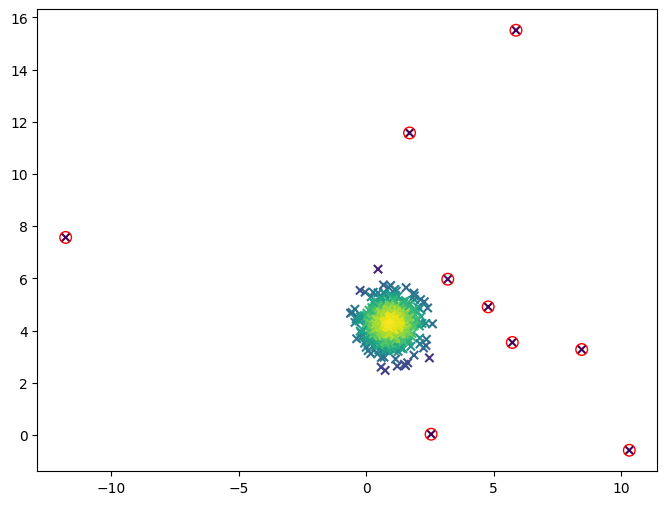

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<tr)[0] #indices for which p<tr
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

In [17]:
X[np.nonzero(p<tr)[0],0]

array([  4.7814587 ,  10.31406003, -11.788679  ,   3.19558624,
         5.86996   ,   2.54160859,   1.69648793,   8.44666544,
         5.72671217])

In [18]:
X[p<tr,0]

array([  4.7814587 ,  10.31406003, -11.788679  ,   3.19558624,
         5.86996   ,   2.54160859,   1.69648793,   8.44666544,
         5.72671217])

Try different values for threshold and report Precision, Recall and F1 Score.

Precision quantifies the number of positive class predictions that actually belong to the positive class.

Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.

F-Measure provides a single score that balances both the concerns of precision and recall in one number.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
tr_list = [0.001, 0.01, 0.02, 0.03, 0.1 , 0.2 , 1]
for tr in tr_list:
    pr = precision_score(y_true, p<=tr) #True Positives / (True Positives + False Positives)
    rc = recall_score(y_true, p<=tr) #True Positives / (True Positives + False Negatives)
    f1 = f1_score(y_true, p<=tr) # 2* (Precision * Recall)/ (Precision + Recall)
    print ("Threshold:" , "{:.3f}".format(tr), " Precision:" , "{:.2f}".format(pr), " Recall: " , "{:.2f}".format(rc) , " F1 Score: ", "{:.2f}".format(f1))


Threshold: 0.001  Precision: 1.00  Recall:  0.80  F1 Score:  0.89
Threshold: 0.010  Precision: 1.00  Recall:  0.90  F1 Score:  0.95
Threshold: 0.020  Precision: 1.00  Recall:  1.00  F1 Score:  1.00
Threshold: 0.030  Precision: 0.77  Recall:  1.00  F1 Score:  0.87
Threshold: 0.100  Precision: 0.07  Recall:  1.00  F1 Score:  0.13
Threshold: 0.200  Precision: 0.02  Recall:  1.00  F1 Score:  0.05
Threshold: 1.000  Precision: 0.02  Recall:  1.00  F1 Score:  0.05


In [20]:
print(p<=tr)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [21]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1]


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is that we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to a Mixture of Gaussian models. Take a look at the following dataset:

X: (450, 2) 
y_true (450,)
X_train: (315, 2) 
X_test (135, 2)


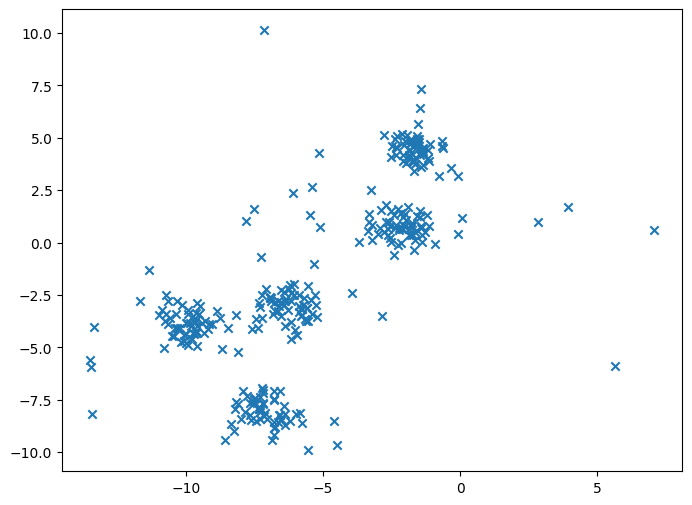

In [22]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])

print('X:', X.shape, '\ny_true', y_true.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.30, random_state=1, shuffle=True)
print('X_train:', X_train.shape, '\nX_test', X_test.shape)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before.


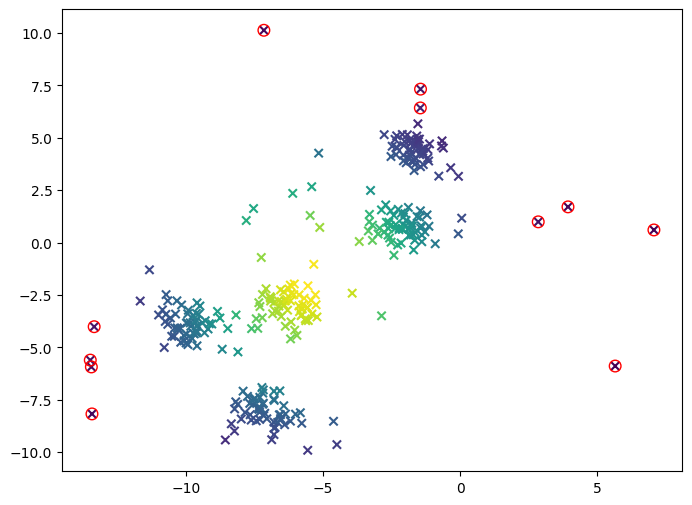

In [23]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_train, mu, sigma2)
plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

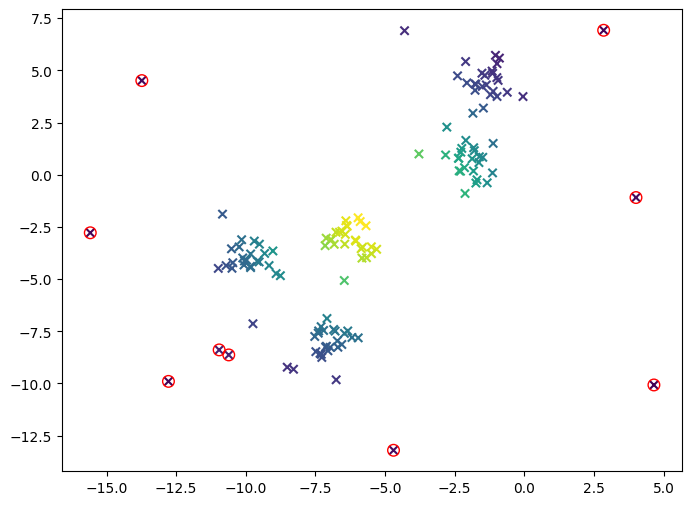

In [24]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma2)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [25]:
from sklearn.mixture import GaussianMixture

# Gaussian mixture model probability distribution
gm = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0, ) # each component has its own general covariance matrix
gm.fit(X_train)

GaussianMixture(n_components=5, random_state=0)

Now we can use the method `gm.score_samples()` which gives a score based on how likely a point is to have been generated by any cluster:

(315,)
-24.67179036061333 -2.8862294523341983


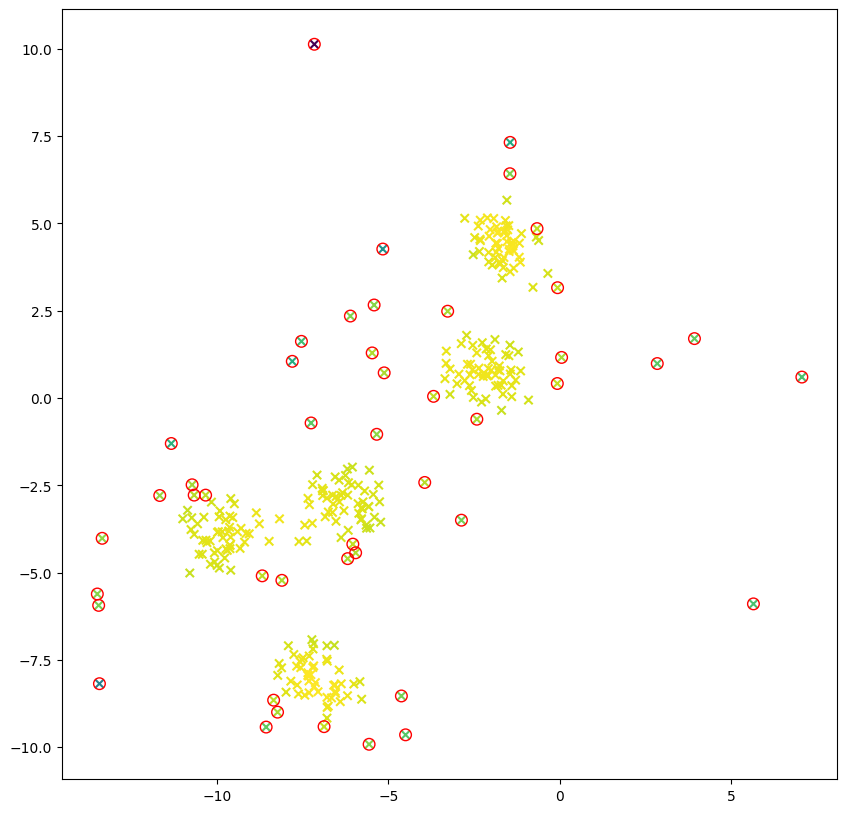

In [26]:
plt.figure(figsize=(10,10))
c = gm.score_samples(X_train)
print(c.shape)
print(c.min(),c.max())

#gm.score_samples returns Log-likelihood of each sample in X under the current model
plt.scatter(X_train[:,0],X_train[:,1],c=gm.score_samples(X_train),cmap='viridis',marker='x')

threshold= -4.8
outliers = np.nonzero(c<threshold)[0]
plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

In [27]:
print(c)

[ -4.36422077  -3.38429693  -4.05587175  -3.52251199  -6.97850107
  -3.79402984  -3.07161123  -3.16948669  -3.88173147  -6.82736057
  -3.3209243   -4.00717905  -3.24483595  -3.49628688  -3.40695648
  -6.31367604  -4.4185486   -4.07140277  -3.35327672  -3.41742598
  -4.16637214  -3.4806842   -3.39153219  -4.12955007  -3.10530585
  -4.24704687  -4.67422114  -3.58541313  -8.70535384  -3.58354243
  -3.92130848  -3.24081679  -3.36701163  -3.55572649  -3.79659459
  -3.50099959  -7.33031159  -3.63839237  -3.3553959   -4.71235766
  -4.0287078   -5.09721511  -3.73603666  -3.53186319  -3.41581069
  -3.26204683  -3.92658995  -3.83938055  -3.50343261  -3.95074726
  -4.36720035  -3.28084165  -3.40025486  -3.93345752  -4.390184
  -4.01292585  -4.45560257  -3.47139907  -4.47413672  -6.47711109
  -4.31729526  -3.06905657  -4.36607529  -3.5622805   -5.2364788
  -3.99337432  -4.80299216  -4.00499192  -3.0476008   -3.7642691
  -5.53260869  -4.00075572  -3.58750163  -5.74178734  -3.15152544
  -3.23398325 

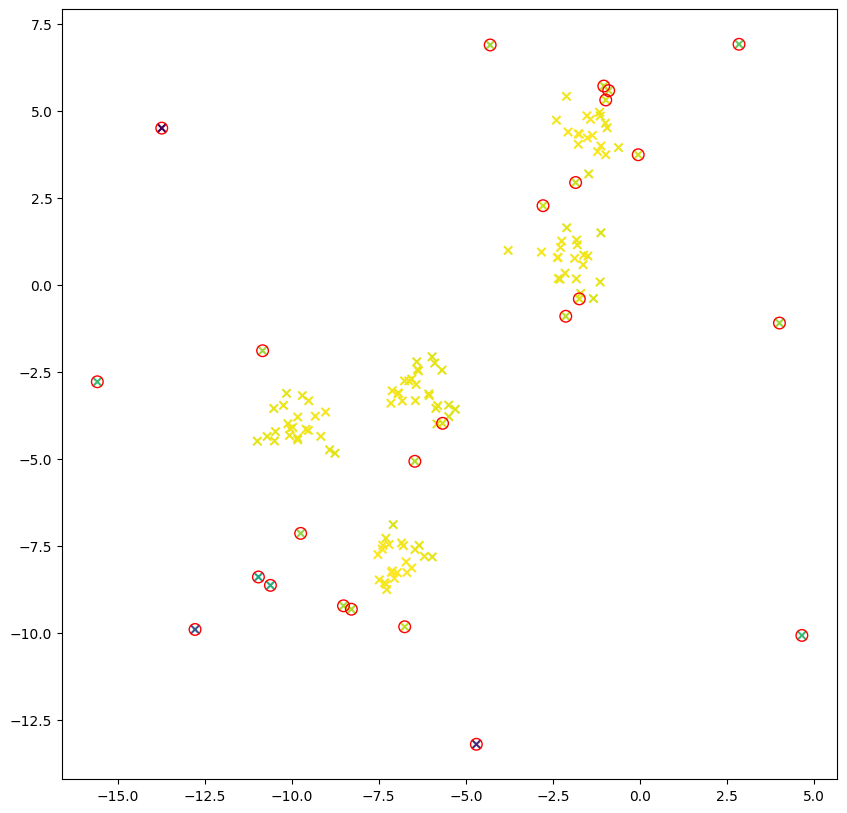

In [28]:
plt.figure(figsize=(10,10))
c = gm.score_samples(X_test)
plt.scatter(X_test[:,0],X_test[:,1],c=gm.score_samples(X_test),cmap='viridis',marker='x')

threshold= -4.8

outliers = np.nonzero(c<threshold)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

What is the variable "`threshold`"? ______________ Why is it negative? __________________________

Now we can use the method `gm.predict_proba()` to spot the points in each of the clusters.

In [29]:
Non_Outliers=np.nonzero(c>=threshold)[0]
X_t=X_train[Non_Outliers]
X_t.shape

(110, 2)

In [30]:
# gm.predict_proba returns the density of each Gaussian component for each sample in X
gm.predict_proba(X_t).shape

(110, 5)

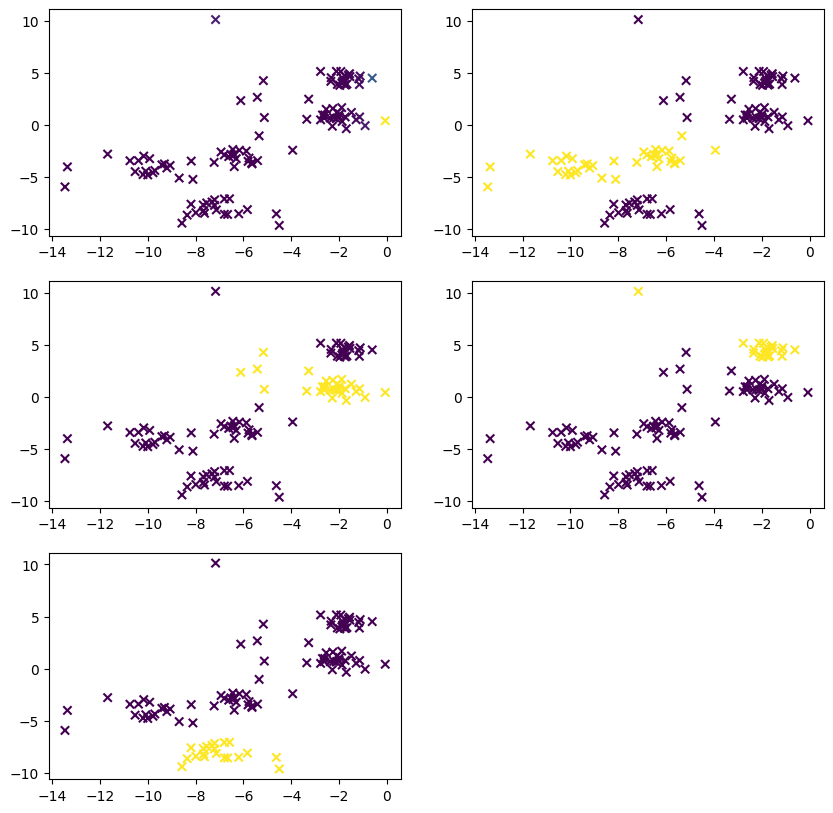

In [31]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_t[:,0],X_t[:,1],c=gm.predict_proba(X_t)[:,i],cmap='viridis',marker='x')

1] What do the functions `gm.score_samples()` and `gm.predict_proba()` return? ___________

2] Why is it important to run them in above sequence? ____________________

3] What is the difference between the two functions?_______________________________


Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

In the cells below, we are going to try two methods to determine the threshold and visit ROC and AUC.

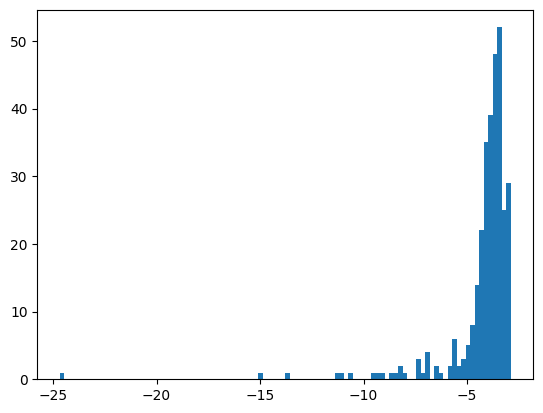

In [32]:
p_gm = gm.score_samples(X_train)
_ = plt.hist (p_gm , bins = 100)

In [33]:
sorted(p_gm)

[-24.67179036061333,
 -15.003114256154289,
 -13.622722475982709,
 -11.380552259228848,
 -11.10759197420886,
 -10.673681056839806,
 -9.555865310686485,
 -9.22521239561513,
 -9.106815910786745,
 -8.705353838553773,
 -8.491754523798344,
 -8.288592409886677,
 -8.21432125978996,
 -8.09859012814924,
 -7.445751218103344,
 -7.399964216157203,
 -7.330311593180857,
 -7.0888143106605055,
 -6.978501067519736,
 -6.974300184643832,
 -6.8591998581258435,
 -6.827360565773027,
 -6.5718660741428305,
 -6.4771110897752395,
 -6.313676042649923,
 -5.9244194176939775,
 -5.741787343079701,
 -5.700263677298914,
 -5.681093914772489,
 -5.614209686985329,
 -5.578383134180445,
 -5.564019489144659,
 -5.532608694636394,
 -5.499761207850035,
 -5.415054961268564,
 -5.236478798022189,
 -5.234861452967215,
 -5.097215109380536,
 -4.988007222836532,
 -4.930421010934115,
 -4.924153846434617,
 -4.888400241789263,
 -4.864449309455329,
 -4.8345155410424505,
 -4.827371574227015,
 -4.802992156537621,
 -4.779902131834267,
 -4.71

In [34]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

p_gm = gm.score_samples(X_train) #score_samples will compute the weighted log probabilities for each sample

print ("Method 1: ")

for tr in [  -20, -10 ,-7, -6 ,  -5 ]:
   precision = precision_score(y_train, p_gm < tr) #Here, we compare y_train labels to our picks using precision
   recall = recall_score(y_train, p_gm < tr) #Here, we compare y_train labels to our picks using recall
   print('For threshold of ',tr,' \t precision: ', '%.3f' % precision,' recall: ', '%.3f' % recall)




print ("\n\nMethod 2: ")

for i in [1, 10, 20, 30, 100 , 120, 130]:
   tr = sorted(p_gm)[i] #We sort the points by probability
   precision = precision_score(y_train, p_gm < tr)
   recall = recall_score(y_train, p_gm < tr)
   print('For i: ',i,'\t  threshold: ','%.3f'% tr ,'  precision: ', '%.3f' % precision,'  recall: ', '%.3f' % recall)


# NEXT: find the best threshold and try the model on the test set!


Method 1: 
For threshold of  -20  	 precision:  1.000  recall:  0.029
For threshold of  -10  	 precision:  1.000  recall:  0.176
For threshold of  -7  	 precision:  0.889  recall:  0.471
For threshold of  -6  	 precision:  0.880  recall:  0.647
For threshold of  -5  	 precision:  0.737  recall:  0.824


Method 2: 
For i:  1 	  threshold:  -15.003   precision:  1.000   recall:  0.029
For i:  10 	  threshold:  -8.492   precision:  1.000   recall:  0.294
For i:  20 	  threshold:  -6.859   precision:  0.900   recall:  0.529
For i:  30 	  threshold:  -5.578   precision:  0.800   recall:  0.706
For i:  100 	  threshold:  -4.106   precision:  0.330   recall:  0.971
For i:  120 	  threshold:  -3.985   precision:  0.275   recall:  0.971
For i:  130 	  threshold:  -3.915   precision:  0.254   recall:  0.971


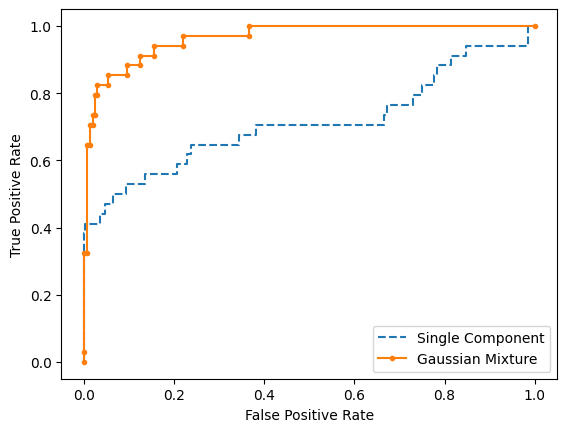

In [35]:
#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from sklearn.mixture import GaussianMixture

gm_sf = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm_sf.fit(X_train)
p = gm_sf.score_samples(X_train)

#ROC curve is plots the true positive rate (TPR or (TP/(TP + FN))) against the false positive rate (FPR or (FP/(TN + FP)))
#true positive rate is the proportion of observations that are predicted to be positive when indeed they are positive
#false positive rate is the proportion of observations that are predicted to be positive when they’re actually negative

fpr_sc, tpr_sc, _ = roc_curve(y_train, -1 * p) # Labels: Valid=0, predictions: Valid = 1 --> need to multiply by -1
fpr_gm, tpr_gm, _ = roc_curve(y_train, -1 * p_gm)

#The more that the ROC curve hugs the top left corner of the plot, the better the model does at classifying the data into categories.
plt.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
plt.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [36]:
print(min(y_train), max(y_train))
print(min(p), max(p))
print(min(p_gm), max(p_gm))

0 1
-18.685266531089894 -4.224305338495419
-24.67179036061333 -2.8862294523341983


In [37]:
from sklearn.metrics import auc
print ("AUC of Single Component" , format( auc(fpr_sc, tpr_sc) , ".3f"))
print ("AUC of Gaussian Mixture" , format( auc(fpr_gm, tpr_gm) , ".3f"))

AUC of Single Component 0.712
AUC of Gaussian Mixture 0.964


In [38]:
from sklearn.metrics import roc_auc_score

#AUC (area under the curve)
print ("AUC of Single Component" , format(  roc_auc_score(y_train, -1 * p)     , ".3f")  )
print ("AUC of Gaussian Mixture" , format(  roc_auc_score(y_train, -1 * p_gm)  , ".3f")  )

AUC of Single Component 0.712
AUC of Gaussian Mixture 0.964


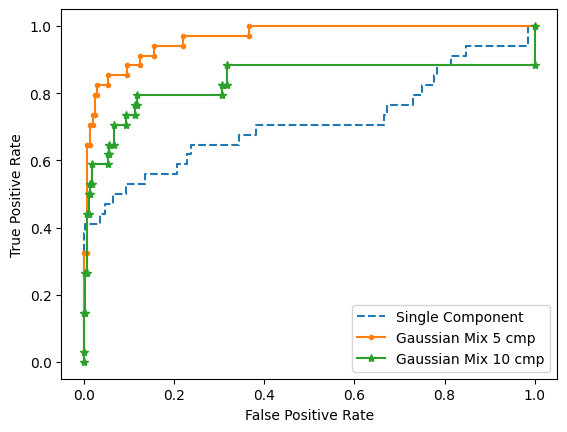

In [39]:
#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from sklearn.mixture import GaussianMixture

gm2 = GaussianMixture(n_components = 10, covariance_type = 'full', random_state=0, )
gm2.fit(X_train)
p_gm2 = gm2.score_samples(X_train)

fpr_sc, tpr_sc, _ = roc_curve(y_train, -1 * p)
fpr_gm, tpr_gm, _ = roc_curve(y_train, -1 * p_gm)
fpr_gm2, tpr_gm2, _ = roc_curve(y_train, -1 * p_gm2)
plt.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
plt.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mix 5 cmp')
plt.plot(fpr_gm2, tpr_gm2, marker='*', label='Gaussian Mix 10 cmp')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [40]:
!wget https://raw.githubusercontent.com/Sabaae/Dataset/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    #for read mode (r) with binary (b)
    simpsons = pickle.load(f)

--2024-09-08 05:06:46--  https://raw.githubusercontent.com/Sabaae/Dataset/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle’

simpsons.pickle     100%[===================>]  25.46K  --.-KB/s    in 0s      

2024-09-08 05:06:46 (64.5 MB/s) - ‘simpsons.pickle’ saved [26076/26076]



Plot a histogram of the rating distribution for all Simpsons episodes.


In [41]:
simpsons.values()

dict_values([{"Bart's Not Dead": 6.2, 'Heartbreak Hotel': 6.0, 'My Way or the Highway to Heaven': 6.1, 'Treehouse of Horror XXIX': 5.9, "Baby You Can't Drive My Car": 7.0, 'From Russia Without Love': 6.6, 'Werking Mom': 5.8, 'Krusty the Clown': 6.6, 'Daddicus Finch': 6.8, "'Tis the 30th Season": 6.7, 'Mad About the Toy': 5.7, 'The Girl on the Bus': 6.3, "I'm Dancing as Fat as I Can": 6.9, 'The Clown Stays in the Picture': 6.2, '101 Mitigations': 6.4, "I Want You (She's So Heavy)": 5.8, 'E My Sports': 6.3, 'Bart vs. Itchy & Scratchy': 4.9, "Girl's in the Band": 6.2, "I'm Just a Girl Who Can't Say D'oh": 5.2, "D'oh Canada": 5.3, 'Woo-Hoo Dunnit?': 6.0, 'Crystal Blue-Haired Persuasion': 5.9}, {'Simpsons Roasting on an Open Fire': 8.2, 'Bart the Genius': 7.8, "Homer's Odyssey": 7.4, "There's No Disgrace Like Home": 7.7, 'Bart the General': 8.1, 'Moaning Lisa': 7.6, 'The Call of the Simpsons': 7.8, 'The Telltale Head': 7.7, 'Life on the Fast Lane': 7.5, "Homer's Night Out": 7.4, 'The Crepes

669


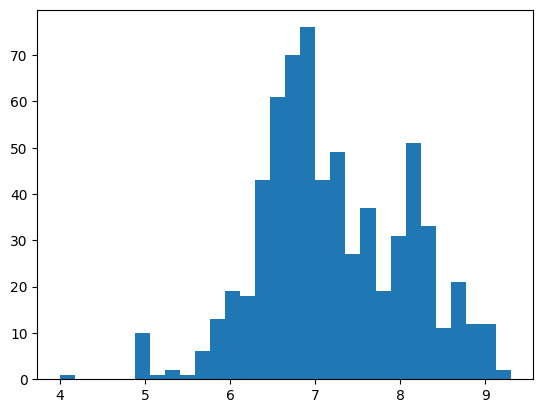

In [42]:
allratings = []
for v in simpsons.values():
    for v1 in v.values():
        allratings.append(v1)
print(len(allratings))
plt.hist(allratings, bins= 30)
plt.show()

Next, use Gaussian Mixture to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? __
* What about the standard deviations? __

In [43]:
gm = GaussianMixture(n_components=2)
gm.fit(np.array(allratings).reshape(-1,1))

print("Mean: ", gm.means_)
print(" \n \n StD: ", np.sqrt(gm.covariances_))


Mean:  [[8.20449347]
 [6.7859272 ]]
 
 
 StD:  [[[0.45788767]]

 [[0.60218053]]]


In [44]:
x = np.array(allratings)
print(x[:5])
f = np.ravel(x).astype(float)
print(f[:5])

[6.2 6.  6.1 5.9 7. ]
[6.2 6.  6.1 5.9 7. ]


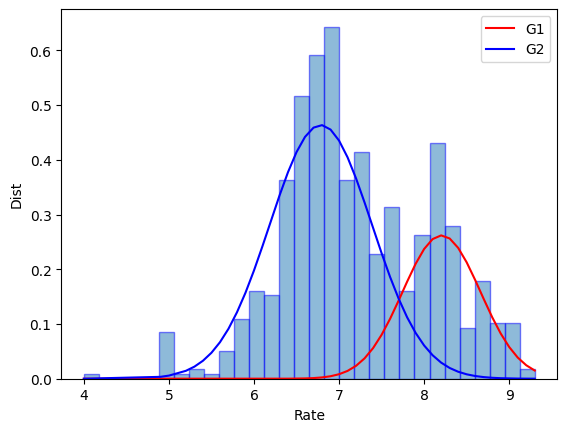

In [45]:
from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.ticker as tkr
import scipy.stats as stats


x = np.array(allratings)

f = np.ravel(x).astype(float)
f = f.reshape(-1,1)

weights = gm.weights_
means = gm.means_
covars = gm.covariances_

plt.hist(f, bins=30, histtype='bar', density=True, ec='blue', alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red', label = "G1")
plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue', label = "G2")
plt.legend()
plt.xlabel("Rate")
plt.ylabel("Dist")
plt.show()

Finally, using the `GuassianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, we have provided code to count the number of episodes predicted to be in the "good" distribution per season, and plot for the same.
Understand the code and answer the question.

* Where is the notable drop-off point? __
* What is the first season with 0 good episodes? __


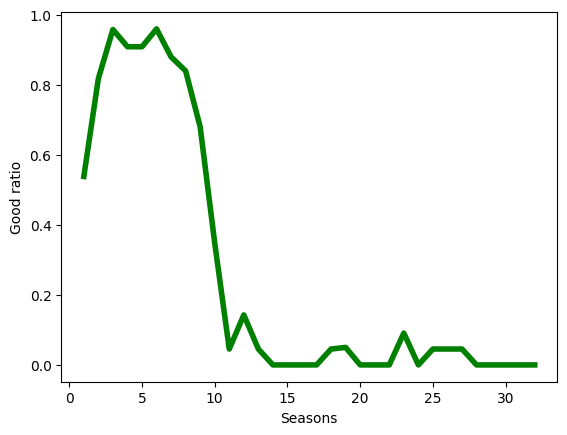

In [46]:
#Let's first associate each component with a good or bad season
if gm.means_[0,0] > gm.means_[1,0]: #True if first component is the good season (ie, higher mean)
     Good_season_index = 0
else:
     Good_season_index = 1

Xs = []
Ys = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
for season, episodes in simpsons.items():
     bad = 0
     good = 0
     for episode in episodes.values():
          if gm.predict(np.array(episode).reshape(-1,1)) == Good_season_index:
               good += 1
          else:
               bad += 1
     Xs.append(season)
     Ys.append(good/(good+bad))
plt.plot(Xs, Ys, lw = 4, color = "green");
plt.xlabel("Seasons")
plt.ylabel("Good ratio")
plt.show()

Reference:

https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/#Summary

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html